# Mixing Probabilistic Circuits with Normalizing Flows

In this notebook, we provide an example of mixing probabilistic circuits (PCs) — implemented using `cirkit` — with normalizing flows (NFs). Probabilistic circuits are able to model complex join densities, while preserving tractability as long as certain structural properties are satisfied. `cirkit` provides the ingredients for compiling such circuits (details in `region-graphs-and-parametrisation.ipynb`). Expressiveness and tractability make circuits good candidates as normalizing flows *base distributions*.

In this example, we try to estimate two *toy* densities in 2 dimensions. First, we adopt the library `zuko`, which implements a wide range of state of the art normalizing flows using `pytorch`. We provide an example of how to wrap a circuit from `cirkit` into a distribution compatible with `zuko`. Then, we compare and discuss a number of training configurations, involving both probabilistic circuits and normalizing flows.

In [13]:
import torch
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import copy

SEED = 47
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

device = 'cuda'

## `zuko` wrapper for `cirkit`

`Zuko`'s backend relies on pytorch distribution objects (`torch.distribution.Distributions`) for base distributions. For our purposes, we can wrap our circuit in a `Distribution` object, defining the `log_prob`.

In [ ]:
from torch import Tensor, Size
from torch.distributions import Distribution

class TorchCircuitDistribution(Distribution):
    # ------------ Distribution object attributes interpretation --------------- #
    # batch_shape: describes the shape of not identically distributed draws. Since our circuit has only one parametrization `batch_shape=Size([1])`
    # event_shape: describe the shape of a single draw (can be dependent). In our case, since it is a scalar value, `event_shape=Size([])` 
    def __init__(self, circuit, batch_shape=Size([1]), event_shape=Size([])):
        super().__init__(batch_shape=batch_shape, event_shape=event_shape )
        
        self.circuit = circuit

    def log_prob(self, x: Tensor):
        return self.circuit(x) # return the circuit log-likelihood

Then, `zuko` base distributions are implemented as `zuko.flows.LazyDistribution` objects. They extend `torch.nn.module`, hence allow for the registration of other modules. The `forward` method returns a pytorch distribution object which, in this case, is our custom `TorchCircuitDistribution`.

In [ ]:
from zuko.flows import LazyDistribution
from cirkit.backend.torch.circuits import TorchCircuit

class TorchCircuitBaseDistribution(LazyDistribution):
    def __init__(self, circuit: TorchCircuit, trainable=False):
        super().__init__()

        if trainable:
            self.add_module('_circuit', circuit) # we register the module if we want it to be trained with the flow
        self.circuit = TorchCircuitDistribution(circuit)

    def forward(self, c: Tensor = None):
        return self.circuit # return the whole circuit

## Experiments

In this section, we estimate two slightly different densities. We can observe that for a flow with a shallow transformation and a normal base distribution, such densities are difficult to be estimated. Replacing the standard base distribution with a pre-trained flow improves the quality of the estimation. In addition, allowing for the circuit to be fine-tuned along with the flow weights leads also to an improvement.

### Training and evaluation loops

We use the same training and evaluation loops for both circuits and flows. Depending on the model, the loop function receives a different forward function

In [16]:
# ---------- Flow forward function ---------- #
def flow_forward(flow, x):
    x = x.unsqueeze(dim=1)
    return flow().log_prob(x)

# ---------- Circuit forward function ---------- #
def circuit_forward(circuit, x):
    x = x.unsqueeze(dim=1)
    return circuit(x)

In [17]:
def training_loop(f, model: torch.nn.Module, train_loader, val_loader, lr, patience=3, tol=1e-6, maximize=False, epochs=100, device='cuda'):\
    # optimizer initialization
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, maximize=maximize)
    losses = []
    
    # --------- Training loop --------- #
    curr, min_loss = 0, float('inf')
    for i in range(1, epochs+1):
        running_loss=0.0
        running_val_loss=0.0
        for input_tensor in train_loader:
            input_tensor = input_tensor.to(device)
            loss = -f(model, input_tensor).mean()
            loss.backward()
            running_loss += loss

            optimizer.step()
            optimizer.zero_grad()
        epoch_loss = (running_loss / len(train_loader)).cpu().detach().numpy()
        losses.append(epoch_loss)

    # --------- Validation loop --------- #
        for input_tensor in val_loader:
            input_tensor = input_tensor.to(device)
            loss = -f(model, input_tensor).mean()
            running_val_loss += loss
        val_loss = (running_val_loss / len(val_loader)).cpu().detach().numpy()
        if val_loss >= min_loss + tol:
            curr += 1
            if curr > patience:
                break
        else:
            curr = 0
            min_loss = val_loss
        if i % 5  == 0:
            print(f'Step: {i}  Average val NLL: {val_loss}')
            
    return losses

def evaluate_model(f, model, test_dataloader, device='cuda') -> list:
    test_running_loss = 0.0
    with torch.no_grad():
        for input_tensor in test_dataloader:
            input_tensor = input_tensor.to(device)
            loss = -f(model, input_tensor).mean()
            test_running_loss += loss

    hold_out = (test_running_loss/len(test_dataloader)).item()
    return hold_out

A utility function to plot a mesh grid of a model estimated density

In [18]:
def print_density(model, f, ax=None, x1_bounds=(-1.5,2.5), x2_bounds=(-1,1.5), device='cuda'):
    model.eval()
    with torch.no_grad():
        num_samples = 400
        x2 = np.linspace(0, 1, num_samples)*(x2_bounds[1] - x2_bounds[0]) + x2_bounds[0]
        x1 = np.linspace(0, 1, num_samples)*(x1_bounds[1] - x1_bounds[0]) + x1_bounds[0]
        x1v, x2v = np.meshgrid(x1, x2)
        X_meshgrid_np = np.stack((x1v,x2v), axis=-1).reshape(-1,2)
        X_meshgrid = torch.from_numpy(X_meshgrid_np).float()
        X_meshgrid = X_meshgrid.to(device)
        log_probs = f(model, X_meshgrid).float()
        log_probs = log_probs.reshape(num_samples, num_samples)
        probs = torch.exp(log_probs)
        instance = ax
        if instance is None:
            instance = plt
        ax = instance.imshow(probs.cpu().detach().numpy(), extent=(*x1_bounds, *x2_bounds), origin="lower")
    return log_probs

### Instantiating a Normalizing Flow using `zuko`

We adopt a lightweight coupling flow, *i.e.,* [NICE (Dinh et al. 2014)](https://arxiv.org/abs/1410.8516). The default base distribution is a multivariate normal distribution with diagonal covariance matrix. The same untrained flow is reused across the experiment configurations.

In [19]:
from zuko.flows import NICE
basic_flow = NICE(              
    features        = 2,        # 2D distribution
    transforms      = 5,        # number of transformations
    hidden_features = (16, 16),   # features of the hidden layer of the transformation
    randmask        = True,     # use a random coupling mask
).to(device=device)    
basic_flow.base                 # flow base distribution

UnconditionalDistribution(DiagNormal(loc: torch.Size([2]), scale: torch.Size([2])))

### Instantiating a Probabilistic Circuit using `cirkit`

For details about the implementation, refer to `region-graphs-and-parametrisation.ipynb`

In [ ]:
from cirkit.templates import region_graph as rg
from cirkit.pipeline import compile
from cirkit.symbolic.layers import GaussianLayer
from cirkit.templates.utils import (
    Parameterization,
    parameterization_to_factory
)

# ----------- Region graph   ----------- #
region_graph = rg.algorithms.FullyFactorized(num_variables=2)

# ----------- Building the symbolic circuit from the RG ----------- #
sum_weight_param = Parameterization(activation='softmax', initialization='normal')

symbolic_circuit = region_graph.build_circuit(
    input_factory=GaussianLayer,
    sum_product='tucker',
    sum_weight_factory=parameterization_to_factory(sum_weight_param),
    num_input_units=8,
    num_sum_units=8,
)
# ----------- Compiling the circuit ----------- #
basic_circuit = compile(symbolic_circuit).to(device)

### Ring-shaped distribution

#### Dataset preparation

We load an artificial dataset containing points drawn from a *ring-shaped* distribution.

In [21]:
from datasets import load_artificial_dataset
from torch.utils.data import DataLoader

batch_size = 128
data = load_artificial_dataset(name='ring', num_samples=5_000, seed=SEED, sigma=0.05)

train_loader = DataLoader( data['train'], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader( data['valid'], batch_size=batch_size, shuffle=False)
test_loader  = DataLoader( data['test'] , batch_size=batch_size, shuffle=False)


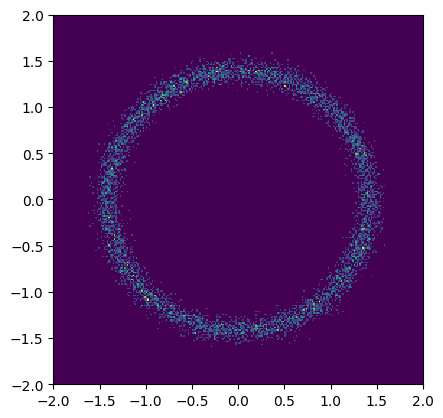

In [22]:
bounds = (-2, 2)
ground_truth = np.concatenate(list(data.values()))
plt.hist2d(*ground_truth.T, bins=256, range=(bounds, bounds), density=True, linewidths=0, rasterized=True)
plt.gca().set_aspect('equal', adjustable='box')

#### Basic NF

We train the basic Normalizing Flow previously initialized.

In [23]:
trained_flow = copy.deepcopy(basic_flow) # copy the prototype

_ = training_loop(
    model           = trained_flow,
    f               = flow_forward,
    train_loader    = train_loader,
    val_loader      = valid_loader,
    epochs          = 500,
    lr              = 0.005,
    device          = device,
)

Step: 5  Average val NLL: 2.1033763885498047
Step: 10  Average val NLL: 1.651458978652954
Step: 15  Average val NLL: 1.5758607387542725
Step: 20  Average val NLL: 1.499655842781067


As for the NF, we train the basic PC previously initialized.

In [24]:
trained_circuit = copy.deepcopy(basic_circuit) # copy the prototype

_ = training_loop(
        model       = trained_circuit,
        f           = circuit_forward,
        train_loader= train_loader,
        val_loader  = valid_loader,
        epochs      = 500,
        lr          = 0.05,
        device      = device,
)

Step: 5  Average val NLL: 1.3469688892364502
Step: 10  Average val NLL: 1.3701229095458984
Step: 15  Average val NLL: 1.3435323238372803


#### NF+Frozen PC

Here we define a new flow with the very same transformation of the `basic_flow` but replacing the base distribution with our pre-trained circuit. Here, we *freeze* the weights of the circuit, not including them in the training parameters.

In [25]:
from zuko.flows import Flow

frozen_circuit = copy.deepcopy(trained_circuit) # copy the prototype
transform = copy.deepcopy(basic_flow.transform) # copy the prototype transform

# wrap our circuit, not allowing for training
basic_distribution_circuit = TorchCircuitBaseDistribution(frozen_circuit, trainable=False)

# initialize a new flow with the original transform and our custom circuit base distribution
custom_flow = Flow(transform=transform, base=basic_distribution_circuit)    

# train the custom flow
_ = training_loop(
        model           = custom_flow,
        f               = flow_forward,
        train_loader    = train_loader,
        val_loader      = valid_loader,
        epochs          = 500,
        lr              = 0.005,
        device          = device,
    )

Step: 5  Average val NLL: 1.1999735832214355
Step: 10  Average val NLL: 1.1519731283187866
Step: 15  Average val NLL: 1.165776252746582
Step: 20  Average val NLL: 1.1396021842956543


#### NF+PC

Again, we define a new flow with the very same transformation of the `basic_flow`. We replace the base distribution with our pre-trained circuit but allowing for fine-tuning its parameters along with the transformation.

In [26]:
circuit = copy.deepcopy(trained_circuit)        # copy the prototype
transform = copy.deepcopy(basic_flow.transform) # copy the prototype transform

# wrap our circuit, allowing for training
basic_distribution_circuit_2 = TorchCircuitBaseDistribution(circuit, trainable=True)

# initialize a new flow with the original transform and our custom circuit base distribution

# train the custom flow
custom_flow_2 = Flow(transform=transform, base=basic_distribution_circuit_2)
_ = training_loop(
        model           = custom_flow_2,
        f               = flow_forward,
        train_loader    = train_loader,
        val_loader      = valid_loader,
        epochs          = 500,
        lr              = 0.005,
        device          = device,
    )

Step: 5  Average val NLL: 1.0473884344100952


#### Results

We evaluate our models on the test set

In [27]:
hold_out = [None] * 5

hold_out[1] = evaluate_model(
            model=trained_flow,
            f=flow_forward,
            test_dataloader=test_loader,
            device=device,
)

hold_out[2] = evaluate_model(
            model=trained_circuit,
            f=circuit_forward,
            test_dataloader=test_loader,
            device=device,
)

hold_out[3] = evaluate_model(
            model=custom_flow,
            f=flow_forward,
            test_dataloader=test_loader,
            device=device,
)

hold_out[4] = evaluate_model(
            model=custom_flow_2,
            f=flow_forward,
            test_dataloader=test_loader,
            device=device,
)
hold_out

[None,
 1.471468448638916,
 1.2785756587982178,
 1.1624338626861572,
 0.9933033585548401]

And plot the results.

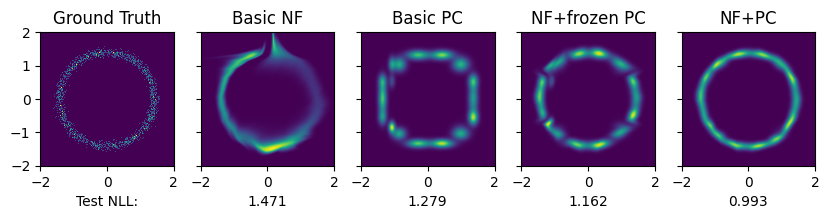

In [28]:
# ------------- Plotting ground truth and estimated densities ----------------- #
fig, axes   = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,3))

# ------------- Ground truth ----------------- #
hist=axes[0].hist2d(*ground_truth.T, bins=256, range=(bounds, bounds), density=True, linewidths=0, rasterized=True)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_title('Ground Truth')
axes[0].set_xlabel('Test NLL:')

# ------------- Basic NF ----------------- #
print_density(trained_flow, flow_forward, ax=axes[1], x1_bounds=bounds, x2_bounds=bounds, device=device)
axes[1].set_title('Basic NF')
axes[1].set_xlabel(f'{hold_out[1]:.3f}')

# ------------- Basic PC ----------------- #
print_density(trained_circuit, circuit_forward, ax=axes[2], x1_bounds=bounds, x2_bounds=bounds, device=device)
axes[2].set_title('Basic PC')
axes[2].set_xlabel(f'{hold_out[2]:.3f}')

# ------------- NF+frozen PC ----------------- #
print_density(custom_flow, flow_forward, ax=axes[3], x1_bounds=bounds, x2_bounds=bounds, device=device)
axes[3].set_title('NF+frozen PC')
axes[3].set_xlabel(f'{hold_out[3]:.3f}')

# ------------- NF+PC ----------------- #
print_density(custom_flow_2, flow_forward, ax=axes[4], x1_bounds=bounds, x2_bounds=bounds, device=device)
axes[4].set_title('NF+PC')
_=axes[4].set_xlabel(f'{hold_out[4]:.3f}')

# ------------- Making the colormap uniform across the plots ----------------- #
vmin = float('inf')
vmax = float('-inf')
# axes[0].axis('off')
hmin, hmax = hist[3].get_clim()
vmin = min(vmin, hmin/len(train_loader.dataset))
vmax = max(vmax, hmax/len(train_loader.dataset))
for ax in axes[1:]:
    # ax.axis('off')
    vmin = min(vmin, ax.get_images()[0].get_array().min())
    vmax = max(vmax, ax.get_images()[0].get_array().max())
for ax in axes[1:]:
    ax.get_images()[0].set_clim(vmin=vmin, vmax=vmax)


### Spiral-shape distribution

#### Dataset preparation

We load an artificial dataset containing points drawn from a *spiral-shaped* distribution.

In [29]:
batch_size = 128
data = load_artificial_dataset(name='spiral', num_samples=5_000, seed=SEED, sigma=0.2)

train_loader = DataLoader( data['train'], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader( data['valid'], batch_size=batch_size, shuffle=False)
test_loader  = DataLoader( data['test'] , batch_size=batch_size, shuffle=False)


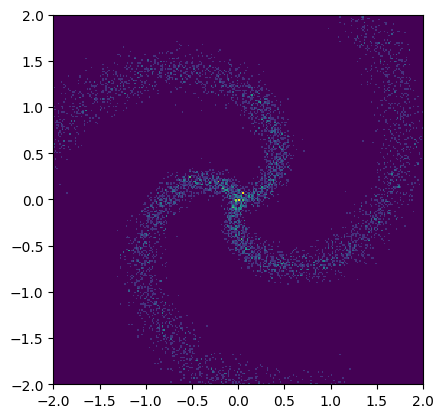

In [30]:
bounds = (-2, 2)
ground_truth = np.concatenate(list(data.values()))
plt.hist2d(*ground_truth.T, bins=256, range=(bounds, bounds), density=True, linewidths=0, rasterized=True)
plt.gca().set_aspect('equal', adjustable='box')

#### Basic NF

We train the basic Normalizing Flow previously initialized.

In [31]:
trained_flow = copy.deepcopy(basic_flow) # copy the prototype

_ = training_loop(
    model           = trained_flow,
    f               = flow_forward,
    train_loader    = train_loader,
    val_loader      = valid_loader,
    epochs          = 500,
    lr              = 0.005,
    device          = device,
)

Step: 5  Average val NLL: 2.6811788082122803
Step: 10  Average val NLL: 2.572209358215332
Step: 15  Average val NLL: 2.4464340209960938
Step: 20  Average val NLL: 2.3608341217041016
Step: 25  Average val NLL: 2.3022403717041016
Step: 30  Average val NLL: 2.2659425735473633
Step: 35  Average val NLL: 2.215879440307617
Step: 40  Average val NLL: 2.22873592376709


As for the NF, we train the basic PC previously initialized.

In [32]:
trained_circuit = copy.deepcopy(basic_circuit) # copy the prototype

_ = training_loop(
        model       = trained_circuit,
        f           = circuit_forward,
        train_loader= train_loader,
        val_loader  = valid_loader,
        epochs      = 500,
        lr          = 0.05,
        device      = device,
)

Step: 5  Average val NLL: 2.1133973598480225
Step: 10  Average val NLL: 2.0757226943969727


#### NF+Frozen PC

Here we define a new flow with the very same transformation of the `basic_flow` but replacing the base distribution with our pre-trained circuit. Here, we *freeze* the weights of the circuit, not including them in the training parameters.

In [33]:
frozen_circuit = copy.deepcopy(trained_circuit) # copy the prototype
transform = copy.deepcopy(basic_flow.transform) # copy the prototype transform

# wrap our circuit, not allowing for training
basic_distribution_circuit = TorchCircuitBaseDistribution(frozen_circuit, trainable=False)

# initialize a new flow with the original transform and our custom circuit base distribution
custom_flow = Flow(transform=transform, base=basic_distribution_circuit)    

# train the custom flow
_ = training_loop(
        model           = custom_flow,
        f               = flow_forward,
        train_loader    = train_loader,
        val_loader      = valid_loader,
        epochs          = 500,
        lr              = 0.005,
        device          = device,
    )

Step: 5  Average val NLL: 1.9790362119674683
Step: 10  Average val NLL: 1.9341130256652832
Step: 15  Average val NLL: 1.95265531539917


#### NF+PC

Again, we define a new flow with the very same transformation of the `basic_flow`. We replace the base distribution with our pre-trained circuit but allowing for fine-tuning its parameters along with the transformation.

In [34]:
circuit = copy.deepcopy(trained_circuit)        # copy the prototype
transform = copy.deepcopy(basic_flow.transform) # copy the prototype transform

# wrap our circuit, allowing for training
basic_distribution_circuit_2 = TorchCircuitBaseDistribution(circuit, trainable=True)

# initialize a new flow with the original transform and our custom circuit base distribution

# train the custom flow
custom_flow_2 = Flow(transform=transform, base=basic_distribution_circuit_2)
_ = training_loop(
        model           = custom_flow_2,
        f               = flow_forward,
        train_loader    = train_loader,
        val_loader      = valid_loader,
        epochs          = 500,
        lr              = 0.005,
        device          = device,
    )

Step: 5  Average val NLL: 1.88126540184021
Step: 10  Average val NLL: 1.8582775592803955
Step: 15  Average val NLL: 1.8509305715560913


#### Results

We evaluate our models on the test set

In [35]:
hold_out = [None] * 5

hold_out[1] = evaluate_model(
            model=trained_flow,
            f=flow_forward,
            test_dataloader=test_loader,
            device=device,
)

hold_out[2] = evaluate_model(
            model=trained_circuit,
            f=circuit_forward,
            test_dataloader=test_loader,
            device=device,
)

hold_out[3] = evaluate_model(
            model=custom_flow,
            f=flow_forward,
            test_dataloader=test_loader,
            device=device,
)

hold_out[4] = evaluate_model(
            model=custom_flow_2,
            f=flow_forward,
            test_dataloader=test_loader,
            device=device,
)
hold_out

[None,
 2.2396676540374756,
 2.0494580268859863,
 1.8788666725158691,
 1.810505986213684]

And plot the results.

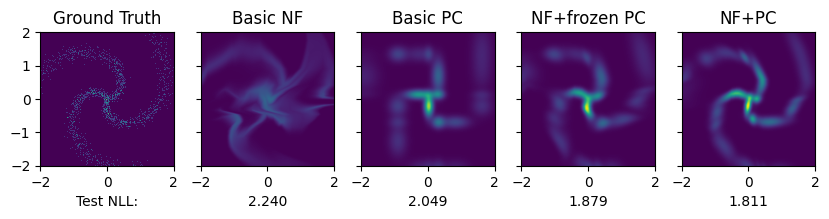

In [36]:
# ------------- Plotting ground truth and estimated densities ----------------- #
fig, axes   = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,3))

# ------------- Ground truth ----------------- #
hist=axes[0].hist2d(*ground_truth.T, bins=256, range=(bounds, bounds), density=True, linewidths=0, rasterized=True)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_title('Ground Truth')
axes[0].set_xlabel('Test NLL:')

# ------------- Basic NF ----------------- #
print_density(trained_flow, flow_forward, ax=axes[1], x1_bounds=bounds, x2_bounds=bounds, device=device)
axes[1].set_title('Basic NF')
axes[1].set_xlabel(f'{hold_out[1]:.3f}')

# ------------- Basic PC ----------------- #
print_density(trained_circuit, circuit_forward, ax=axes[2], x1_bounds=bounds, x2_bounds=bounds, device=device)
axes[2].set_title('Basic PC')
axes[2].set_xlabel(f'{hold_out[2]:.3f}')

# ------------- NF+frozen PC ----------------- #
print_density(custom_flow, flow_forward, ax=axes[3], x1_bounds=bounds, x2_bounds=bounds, device=device)
axes[3].set_title('NF+frozen PC')
axes[3].set_xlabel(f'{hold_out[3]:.3f}')

# ------------- NF+PC ----------------- #
print_density(custom_flow_2, flow_forward, ax=axes[4], x1_bounds=bounds, x2_bounds=bounds, device=device)
axes[4].set_title('NF+PC')
_=axes[4].set_xlabel(f'{hold_out[4]:.3f}')

# ------------- Making the colormap uniform across the plots ----------------- #
vmin = float('inf')
vmax = float('-inf')
# axes[0].axis('off')
hmin, hmax = hist[3].get_clim()
vmin = min(vmin, hmin/len(train_loader.dataset))
vmax = max(vmax, hmax/len(train_loader.dataset))
for ax in axes[1:]:
    # ax.axis('off')
    vmin = min(vmin, ax.get_images()[0].get_array().min())
    vmax = max(vmax, ax.get_images()[0].get_array().max())
for ax in axes[1:]:
    ax.get_images()[0].set_clim(vmin=vmin, vmax=vmax)
